In [1]:
import numpy as np
from scipy.integrate import quad, odeint, solve_ivp
from scipy.special import kn
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math
from numpy import cos, sin, pi, log10
import pandas as pd
import matplotlib.tri as tri

import lib.config as config

from importlib import reload

path = '/Users/Tae/Desktop/N_effective/Type_I_variant/main_code_v2/'
import os
os.chdir(path)

import lib.utils
import lib.Xsecs
import lib.cosmo_def

#%matplotlib inline
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{eufrak}'
plt.rcParams['text.usetex'] = True

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [2]:
mN_val = 10 # MeV

coupling_O = -1

prefix_loc = '/Users/Tae/Desktop/N_effective/Type_I_variant/main_code_v2/data_m_scan'
plot_loc = '/Desktop/N_effective/Type_I_variant/main_code_v2/data_m_scan/plots'

#'''
inputs = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}_flav2/input_variables_mN_{mN_val}.csv')

Ty_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}_flav2/photon_Temperatures_mN_{mN_val}.csv')
Tnu_e_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}_flav2/nu_e_Temperatures_mN_{mN_val}.csv')
Tnu_mu_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}_flav2/nu_mu_Temperatures_mN_{mN_val}.csv')
Tchi_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}_flav2/chi_Temperatures_mN_{mN_val}.csv')


inputs = inputs[np.array([(Ty_df.loc[99,:] > 1e-5)]).T]

Tnu_e_df = Tnu_e_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T    # .T[np.array([(Ty_df.loc[99,:] > 1e-5)]).T].T
Tnu_mu_df = Tnu_mu_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T  # .T[np.array([(Ty_df.loc[99:] > 1e-5)]).T].T
Tchi_df = Tchi_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T   # .T[np.array([(Ty_df.loc[99,:] > 1e-5)]).T].T
Ty_df = Ty_df.T[Ty_df.loc[99,:] > 1e-5].T


time = np.logspace(np.log10(8e-3), np.log10(5e10), 600)

MeV_to_invsec = config.MeV_to_invsec

In [3]:
# N_eff Grid search 
tot_case = inputs.shape[0]
Neff_tot_arr = []
Neff_nu_arr = []
Geff_arr = []

for case_num in range(tot_case):

    ##############################
    ### Assign input variables ###
    ##############################
    
    config.config_params['Lchi'] = 3e-3
    config.config_params['chi_flav'] = 2
    
    config.config_params['m_nl1'] = inputs.iloc[case_num,:]['M_nu']
    config.config_params['m_nl2'] = inputs.iloc[case_num,:]['M_nu']
    config.config_params['m_nl3'] = inputs.iloc[case_num,:]['M_nu']
    
    config.config_params['mN1'] = mN_val
    config.config_params['mN2'] = mN_val
    config.config_params['mN3'] = mN_val
    
    config.config_params['Mass_chi'] = 1e-12
    
    
    Lchi = config.config_params['Lchi']
    
    m_nl1 = config.config_params['m_nl1']
    m_nl2 = config.config_params['m_nl2']
    m_nl3 = config.config_params['m_nl3']
    
    mN1 = config.config_params['mN1']
    mN2 = config.config_params['mN2']
    mN3 = config.config_params['mN3']
    
    chi_flav = config.config_params['chi_flav']
    
    config.config_params['Lnu'] = 10**coupling_O
    config.config_params['Mass_phi'] = inputs.iloc[case_num,:]['M_phi']
    
    Lnu = config.config_params['Lnu']
    Mass_phi = config.config_params['Mass_phi']

    reload(lib.utils)
    reload(lib.Xsecs)
    reload(lib.cosmo_def)
    
    from lib.utils import *
    from lib.Xsecs import *
    from lib.cosmo_def import *

    # Decay width of phi
    phi_decayW = decayWidth_phi(chi_flav, Lchi, Mass_phi)
    
    # G_eff of chi SI
    Geffchi_v = Geffchi(Lchi, Mass_phi)
    
    # Neff Definition
    def Neff_nu(Ty, Tnu_e, Tnu_mu):
        return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu))/rho_y(Ty)
    
    def Neff(Ty, Tnu_e, Tnu_mu, Tchi):
        return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu) + rho_chi(Tchi, chi_flav))/rho_y(Ty)
    
    case_dep_df = pd.DataFrame()
    #case_dep_df['time'] = time
    case_dep_df['Ty'] = Ty_df.iloc[:,case_num]
    case_dep_df['Tnu_e'] = Tnu_e_df.iloc[:,case_num]
    case_dep_df['Tnu_mu'] = Tnu_mu_df.iloc[:,case_num]
    case_dep_df['Tchi'] = Tchi_df.iloc[:,case_num]
    
    case_dep_df['Tnu_e/Ty'] = case_dep_df['Tnu_e']/case_dep_df['Ty']
    case_dep_df['Tnu_mu/Ty'] = case_dep_df['Tnu_mu']/case_dep_df['Ty']
    case_dep_df['Tchi/Ty'] = case_dep_df['Tchi']/case_dep_df['Ty']

    if case_dep_df['Ty'].iloc[-1]<1e-20:
        N_eff_tot = 3.5
        N_eff_nu = 3.5
    else:
        N_eff_tot = Neff(case_dep_df['Ty'].iloc[-1],
                         case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1],
                         case_dep_df['Tchi'].iloc[-1])
    
        N_eff_nu = Neff_nu(case_dep_df['Ty'].iloc[-1],
                           case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1])
    
    Geff_arr.append([3*m_nl1, Mass_phi, Geffchi_v])
    Neff_tot_arr.append([3*m_nl1, Mass_phi, N_eff_tot])
    Neff_nu_arr.append([3*m_nl1, Mass_phi, N_eff_nu])

Geff_arr = np.array(Geff_arr)
Neff_tot_arr = np.array(Neff_tot_arr)
Neff_nu_arr = np.array(Neff_nu_arr)

/var/folders/c9/ryvj4ffx2lg2rp0pw0m8kdcw0000gn/T/ipykernel_40610/2383668399.py:153: RuntimeWarning: divide by zero encountered in log10
  MCMC_interp = interp1d(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]))
/var/folders/c9/ryvj4ffx2lg2rp0pw0m8kdcw0000gn/T/ipykernel_40610/2383668399.py:155: RuntimeWarning: divide by zero encountered in log10
  plt.plot(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]), c = 'purple')


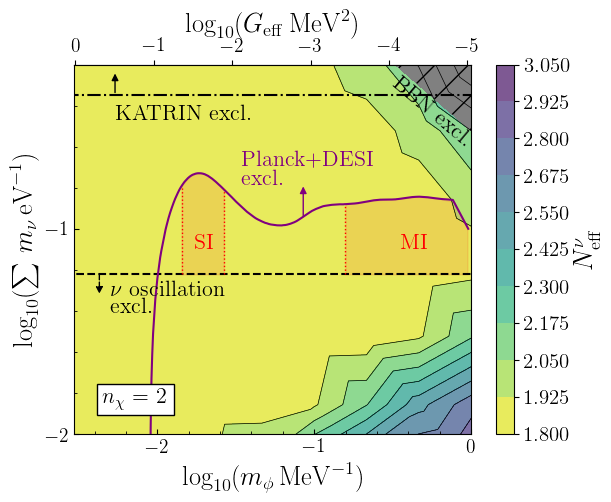

In [5]:
from matplotlib.colors import ListedColormap

def colormap_with_alpha(cmap_name, alpha=0.5):
    base = mpl.colormaps.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, base.N))
    colors[:, -1] = alpha  # Set alpha channel
    return ListedColormap(colors)

axisfontsize = 19
intextsize = 16

lighter_cmap = colormap_with_alpha('viridis_r', alpha=0.7)

xlower = -2.53
xupper = 0
ylower = -8
yupper = -6.2

Neff_nu_arr_ref = Neff_nu_arr[((Neff_nu_arr[:,2]>0.1) 
                               & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                               & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]


Geff_arr_ref = Geff_arr[((Neff_nu_arr[:,2]>0.1) 
                         & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                         & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]

Neff_tot_arr_ref = Neff_tot_arr[((Neff_nu_arr[:,2]>0.1) 
                                 & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                                 & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]


vmin = 1.8
vmax = 3.05

level = np.arange(vmin,vmax,5)

# Convert to log-space before triangulation (assuming no zero/negative values)
x = Neff_nu_arr_ref[:, 1]
y = Neff_nu_arr_ref[:, 0] 
z = Neff_nu_arr_ref[:, 2]

x_log = np.log10(x)
y_log = np.log10(1e6*y)

# Create triangulation
triang = tri.Triangulation(x_log, y_log)


'''
# Check triangulation quality
plt.figure(figsize=(6,6))
plt.triplot(triang, 'k-', alpha=0.3)  # Visualize triangulation
plt.scatter(x_log, y_log, c=z, cmap='cividis_r', marker='o')
plt.xlim(-3.5, 0)
plt.ylim(-12.5, -7)
plt.clim(2.25,3.4)
plt.xlabel("log10(X)")
plt.ylabel("log10(Y)")
plt.title("Triangulation Check")
plt.show()
'''


# Plot tricontour with improved triangulation
plt.figure()

contour_levels = np.linspace(1.8,3.05,11)# [2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05]

plt.tricontour(triang, z, levels=contour_levels, linewidths=0.5, colors='k', vmin = vmin, vmax = vmax)
contour = plt.tricontourf(triang, z, levels=contour_levels, cmap=lighter_cmap, vmin = vmin, vmax = vmax)

xticks = np.arange(-3, 1, 1)
yticks = np.arange(-13, 1, 1)
plt.xticks(ticks=xticks)
plt.yticks(ticks=yticks)

plt.xlim(xlower, xupper)
plt.ylim(ylower+6, yupper+6)

custom_ticks = np.linspace(1.8,3.05,11) 

cbar = plt.colorbar(contour)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r"$N_{\rm{eff}}^{\nu}$", size=axisfontsize)
cbar.set_ticks(custom_ticks)


secxlab = plt.gca().secondary_xaxis(location = 'top', 
                                    functions = (lambda x: np.log10(Geffchi(Lchi, 10**x)), 
                                                 lambda x: np.log10(Geffchi(Lchi, 10**x))))
secxlab.set_xlabel(r'$\log_{10}(G_{\rm eff}\,\rm{MeV}^2)$', size=axisfontsize)
secxlab.tick_params(labelsize = 14)

plt.tick_params(axis='both', direction="in", which='both', labelsize=14)
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.xlabel(r"$\log_{10} (m_\phi \,\rm{MeV}^{-1})$", fontsize=axisfontsize)
plt.ylabel(r"$\log_{10} (\sum\, m_{\nu}\, \rm{eV}^{-1})$", fontsize=axisfontsize)

#plt.grid(color = 'dimgray',ls='dashed', alpha = 0.4)

# upper limit
# KATRIN bound
Mnu_KATRIN = 0.45
logMnu_KATRIN = np.log10(Mnu_KATRIN)
plt.hlines(logMnu_KATRIN,-10, 1 , color = 'k', ls = 'dashdot')
plt.text(-2.27, -0.47, "KATRIN excl.", fontsize=intextsize, color='k')
plt.annotate("", xytext = (-2.27,-0.35), xy=(-2.27,-0.23), arrowprops=dict(arrowstyle="-|>",color = 'k'))

# lower limit
# Oscillation minima : Sum of neutrino mass > 0.06 eV
Mnu_osc = 0.06
logMnu_osc = np.log10(0.06)
plt.hlines(logMnu_osc,-10, 1 , color = 'k', ls = 'dashed')
plt.text(-2.3, -1.33, r"\noindent$\nu$ oscillation \\excl.", fontsize=intextsize, color='k')
plt.annotate("", xytext = (-2.37,-1.21), xy=(-2.37,-1.33), arrowprops=dict(arrowstyle="-|>",color = 'k', ls = 'dashed'))


# DESI + Planck MCMC
Mnu_DP_SI = 0.149
Mnu_DP_MI = 0.129

logMnu_DP_SI = np.log10(Mnu_DP_SI)
logMnu_DP_MI = np.log10(Mnu_DP_MI)

def reg_f(x, refval):
    fx = []
    for xi in x:
        val = 0.5*xi-1.3
        fx.append(max(val, refval))
    return fx

MClog10Geff_shift = - 0.5*np.log10(0.424)

logGeff_MI_low = -3.63 + MClog10Geff_shift
logGeff_SI_low = -1.84-0.24 + MClog10Geff_shift
logGeff_SI_upp = -1.84+0.30 + MClog10Geff_shift

logMphi_MI_low = log10(Geff_to_Mphi(Lchi, 10**logGeff_MI_low))
logMphi_SI_upp = log10(Geff_to_Mphi(Lchi, 10**logGeff_SI_low))
logMphi_SI_low = log10(Geff_to_Mphi(Lchi, 10**logGeff_SI_upp))

reg_1 = np.linspace(logMphi_SI_low, logMphi_SI_upp, 10) # SI
reg_2 = np.linspace(logMphi_MI_low, -0.023, 10)      # MI

SI_lbound = reg_f(reg_1, logMnu_osc)
MI_lbound = reg_f(reg_2, logMnu_osc)

MCMC_cut = np.loadtxt(f'./MCMC_cut/{chi_flav}DR_contours.txt', skiprows=1)
MCMC_cut = np.concatenate([MCMC_cut,np.array([[-5.01,1e-1]])])
MCMC_interp = interp1d(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]))

plt.plot(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]), c = 'purple')
plt.text(-1.47, -0.7, r"\noindent Planck+DESI\\ excl.", fontsize=intextsize, color='purple')
plt.annotate("", xytext = (-1.07,-0.95), xy=(-1.07,-0.78), arrowprops=dict(arrowstyle="-|>",color = 'purple'))


plt.fill_between(reg_1, SI_lbound, MCMC_interp(reg_1), color = 'r', alpha = 0.1)
plt.vlines(reg_1[0], SI_lbound[0], MCMC_interp(reg_1)[0], color='r', linewidth=1., ls = 'dotted')    # left side
plt.vlines(reg_1[-1], SI_lbound[-1], MCMC_interp(reg_1)[-1], color='r', linewidth=1., ls = 'dotted')  # right side
plt.text((logMphi_SI_low+logMphi_SI_upp)/2-0.05, -1.1, "SI", fontsize=intextsize, color='r')

plt.fill_between(reg_2, MI_lbound, MCMC_interp(reg_2), color = 'r', alpha = 0.1)
plt.vlines(reg_2[0], MI_lbound[0], MCMC_interp(reg_2)[0], color='r', linewidth=1., ls = 'dotted')    # left side
plt.text(logMphi_MI_low/2-0.05, -1.1, "MI", fontsize=intextsize, color='r')


# Rule out regions where total N_effective change is larger than 0.4
Neff_tot_arr_ref = Neff_tot_arr_ref[(Neff_tot_arr_ref[:, 2]>3.4)&(np.log10(Neff_tot_arr_ref[:, 1])>-1.5)]

if len(Neff_tot_arr_ref)>=3:
    xref = np.log10(Neff_tot_arr_ref[:,1])
    yref = np.log10(Neff_tot_arr_ref[:,0]*1e6)
    booleans = np.ones(len(xref))
    trig = tri.Triangulation(xref, yref)
    plt.tricontourf(trig, booleans, levels = [0, 1.1], hatches='//',
                    colors='gray', alpha=1)
    plt.text(-0.53, -0.6, "BBN excl.", fontsize=intextsize, color='k', rotation = -40)

plt.text(-2.35, -1.85, r"${ n_{\chi}}$ = "+f"{chi_flav}", fontsize=intextsize, color='k',
         bbox=dict(facecolor='w', alpha=1))

#plt.text(0.5, 0.3, 'Preliminary', transform=plt.gca().transAxes,
#         fontsize=22, color='Gray', alpha=0.8,
#         ha='center', va='center', rotation=0)

#plt.show()
plt.savefig(f"./data_m_scan/plots/mN_{mN_val}MeV_Mnu_Mphi_param_space_1e{int(coupling_O)}_2flav.pdf",bbox_inches = 'tight')

In [ ]:
from matplotlib.colors import ListedColormap

def colormap_with_alpha(cmap_name, alpha=0.5):
    base = mpl.colormaps.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, base.N))
    colors[:, -1] = alpha  # Set alpha channel
    return ListedColormap(colors)

lighter_cmap = colormap_with_alpha('viridis_r', alpha=0.7)

xlower = -2.53
xupper = 0
ylower = -8
yupper = -6.2

Neff_nu_arr_ref = Neff_nu_arr[((Neff_nu_arr[:,2]>0.1) 
                               & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                               & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]


Geff_arr_ref = Geff_arr[((Neff_nu_arr[:,2]>0.1) 
                         & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                         & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]

Neff_tot_arr_ref = Neff_tot_arr[((Neff_nu_arr[:,2]>0.1) 
                                 & (10**(xlower-1)<=Neff_nu_arr[:, 1]) & (Neff_nu_arr[:, 1]<=10**(xupper+1)) 
                                 & (10**(ylower-1)<=Neff_nu_arr[:,0]) & (Neff_nu_arr[:,0]<=10**(yupper+1)))]


vmin = 1.8
vmax = 3.05

level = np.arange(vmin,vmax,5)

# Convert to log-space before triangulation (assuming no zero/negative values)
x = Neff_nu_arr_ref[:, 1]
y = Neff_nu_arr_ref[:, 0] 
z = Neff_nu_arr_ref[:, 2]

x_log = np.log10(x)
y_log = np.log10(1e6*y)

# Create triangulation
triang = tri.Triangulation(x_log, y_log)


'''
# Check triangulation quality
plt.figure(figsize=(6,6))
plt.triplot(triang, 'k-', alpha=0.3)  # Visualize triangulation
plt.scatter(x_log, y_log, c=z, cmap='cividis_r', marker='o')
plt.xlim(-3.5, 0)
plt.ylim(-12.5, -7)
plt.clim(2.25,3.4)
plt.xlabel("log10(X)")
plt.ylabel("log10(Y)")
plt.title("Triangulation Check")
plt.show()
'''


# Plot tricontour with improved triangulation
plt.figure()

contour_levels = np.linspace(1.8,3.05,11)# [2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05]

plt.tricontour(triang, z, levels=contour_levels, linewidths=0.5, colors='k', vmin = vmin, vmax = vmax)
contour = plt.tricontourf(triang, z, levels=contour_levels, cmap=lighter_cmap, vmin = vmin, vmax = vmax)

xticks = np.arange(-3, 1, 1)
yticks = np.arange(-13, 1, 1)
plt.xticks(ticks=xticks)
plt.yticks(ticks=yticks)

plt.xlim(xlower, xupper)
plt.ylim(ylower+6, yupper+6)

custom_ticks = np.linspace(1.8,3.05,11) #[2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05]

cbar = plt.colorbar(contour)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r"$N_{\rm{eff}}^{\nu}$", size=12)
cbar.set_ticks(custom_ticks)


secxlab = plt.gca().secondary_xaxis(location = 'top', 
                                    functions = (lambda x: np.log10(Geffchi(Lchi, 10**x)), 
                                                 lambda x: np.log10(Geffchi(Lchi, 10**x))))
secxlab.set_xlabel(r'$\log_{10}(G_{\rm eff}\,\rm{MeV}^2)$', size=12)


plt.tick_params(axis='both', direction="in", which='both', labelsize=13)
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.xlabel(r"$\log_{10} (m_\phi \,\rm{MeV}^{-1})$", fontsize=13)
plt.ylabel(r"$\log_{10} (\sum\, m_{\nu}\, \rm{eV}^{-1})$", fontsize=13)

#plt.grid(color = 'dimgray',ls='dashed', alpha = 0.4)


# upper limit
# KATRIN bound
Mnu_KATRIN = 0.45
logMnu_KATRIN = np.log10(Mnu_KATRIN)
plt.hlines(logMnu_KATRIN,-10, 1 , color = 'k')
#plt.fill_between(x_log, np.log10(Mnu_KATRIN)*np.ones(len(x_log)), where=(y >= np.log10(Mnu_KATRIN)), color='deepskyblue', alpha=.3)
plt.text(-2.27, -0.47, "KATRIN excl.", fontsize=13, color='k')
plt.annotate("", xytext = (-2.27,-0.35), xy=(-2.27,-0.23), arrowprops=dict(arrowstyle="-|>",color = 'k'))

# lower limit
# Oscillation minima : Sum of neutrino mass > 0.06 eV
Mnu_osc = 0.06
logMnu_osc = np.log10(0.06)
plt.hlines(logMnu_osc,-10, 1 , color = 'k', ls = 'dashed')
plt.text(-2.3, -1.33, r"\noindent$\nu$ oscillation \\excl.", fontsize=13, color='k')
plt.annotate("", xytext = (-2.37,-1.21), xy=(-2.37,-1.33), arrowprops=dict(arrowstyle="-|>",color = 'k', ls = 'dashed'))


# DESI + Planck MCMC
Mnu_DP_SI = 0.149
Mnu_DP_MI = 0.129

logMnu_DP_SI = np.log10(Mnu_DP_SI)
logMnu_DP_MI = np.log10(Mnu_DP_MI)

def reg_f(x, refval):
    fx = []
    for xi in x:
        val = 0.5*xi-1.3
        fx.append(max(val, refval))
    return fx


logGeff_MI_low = -3.63
logGeff_SI_low = -1.84-0.24
logGeff_SI_upp = -1.84+0.30

logMphi_MI_low = log10(Geff_to_Mphi(Lchi, 10**logGeff_MI_low))
logMphi_SI_upp = log10(Geff_to_Mphi(Lchi, 10**logGeff_SI_low))
logMphi_SI_low = log10(Geff_to_Mphi(Lchi, 10**logGeff_SI_upp))

reg_1 = np.linspace(logMphi_SI_low, logMphi_SI_upp, 10) # SI
reg_2 = np.linspace(logMphi_MI_low, -0.023, 10)      # MI

SI_lbound = reg_f(reg_1, logMnu_osc)
MI_lbound = reg_f(reg_2, logMnu_osc)

MCMC_cut = np.loadtxt(f'./MCMC_cut/{chi_flav}DR_contours.txt', skiprows=1)
MCMC_interp = interp1d(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]))

plt.plot(log10(Geff_to_Mphi(Lchi, 10**MCMC_cut.T[0])), log10(MCMC_cut.T[1]), c = 'blue')
plt.text(-1.47, -0.7, r"\noindent Planck+DESI\\ excl.", fontsize=13, color='blue')
plt.annotate("", xytext = (-1.07,-0.98), xy=(-1.07,-0.8), arrowprops=dict(arrowstyle="-|>",color = 'blue'))


plt.fill_between(reg_1, SI_lbound, MCMC_interp(reg_1), color = 'r', alpha = 0.1)
plt.vlines(reg_1[0], SI_lbound[0], MCMC_interp(reg_1)[0], color='r', linewidth=1., ls = 'dotted')    # left side
plt.vlines(reg_1[-1], SI_lbound[-1], MCMC_interp(reg_1)[-1], color='r', linewidth=1., ls = 'dotted')  # right side
plt.text((logMphi_SI_low+logMphi_SI_upp)/2-0.05, -1.1, "SI", fontsize=14, color='r')

plt.fill_between(reg_2, MI_lbound, MCMC_interp(reg_2), color = 'r', alpha = 0.1)
plt.vlines(reg_2[0], MI_lbound[0], MCMC_interp(reg_2)[0], color='r', linewidth=1., ls = 'dotted')    # left side
#plt.vlines(reg_2[-1], MI_lbound[-1], MCMC_interp(reg_2)[-1], color='r', linewidth=1., ls = 'dotted')  # right side
plt.text(logMphi_MI_low/2-0.05, -1.1, "MI", fontsize=14, color='r')


# Rule out regions where total N_effective change is larger than 0.4
Neff_tot_arr_ref = Neff_tot_arr_ref[(Neff_tot_arr_ref[:, 2]>3.4)&(np.log10(Neff_tot_arr_ref[:, 1])>-1.5)]

'''if len(Neff_tot_arr_ref)>=3:
    xref = np.log10(Neff_tot_arr_ref[:,1])
    yref = np.log10(Neff_tot_arr_ref[:,0]*1e6)
    booleans = np.ones(len(xref))
    trig = tri.Triangulation(xref, yref)
    plt.tricontourf(trig, booleans, levels = [0, 1.1], hatches='//',
                    colors='w', alpha=1)
    plt.text(-0.53, -0.6, "BBN excl.", fontsize=13, color='k', rotation = -43)

plt.text(0.5, 0.3, 'Preliminary', transform=plt.gca().transAxes,
         fontsize=22, color='Gray', alpha=0.8,
         ha='center', va='center', rotation=0)'''

#plt.show()
#plt.savefig(f"./data_m_scan/plots/mN_{mN_val}MeV_Mnu_Mphi_param_space_1e{int(coupling_O)}_2flav.pdf",bbox_inches = 'tight')
plt.savefig(f"/Users/Tae/Desktop/Subhajit_plot/frame+exp_bounds+numodel+Cosmo+SIMI_2flav.pdf",bbox_inches = 'tight')

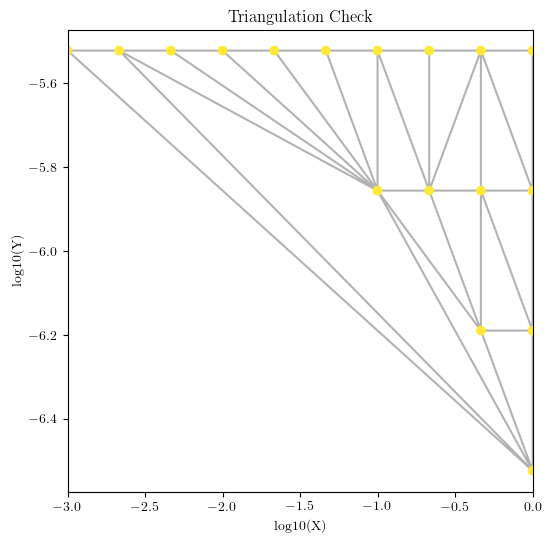

In [9]:
# Rule out regions where total N_effective change is larger than 0.4
Neff_tot_arr_ref = Neff_tot_arr[(Neff_tot_arr[:, 2]>3.4)&(10**(xlower)<=Neff_tot_arr[:, 1])]

xref = np.log10(Neff_tot_arr_ref[:,1])
yref = np.log10(Neff_tot_arr_ref[:,0])
booleans = np.ones(len(xref))

trig = tri.Triangulation(xref, yref)

# Check triangulation quality
plt.figure(figsize=(6,6))
plt.triplot(trig, 'k-', alpha=0.3)  # Visualize triangulation
plt.scatter(xref, yref, c=booleans, cmap='cividis_r', marker='o')
plt.xlim(xlower, xupper)
#plt.ylim(-12.5, -7)
#plt.clim(2.25,3.4)
plt.xlabel("log10(X)")
plt.ylabel("log10(Y)")
plt.title("Triangulation Check")
plt.show()


(-12.5, -7.0)

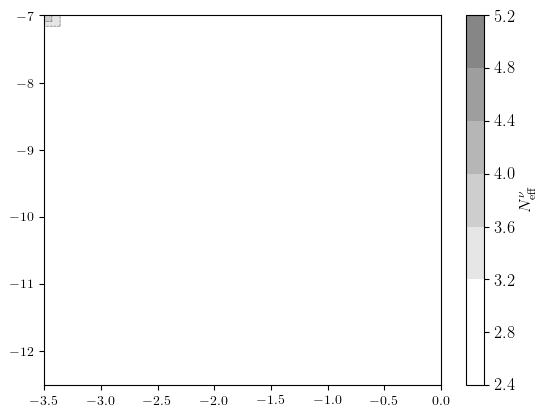

In [15]:
# Total N_eff plot

Neff_nu_arr_ref = Neff_nu_arr[Neff_nu_arr[:,2]>0.1]
Geff_arr_ref = Geff_arr[Neff_nu_arr[:,2]>0.1]
Neff_tot_arr_ref = Neff_tot_arr[Neff_nu_arr[:,2]>0.1]

vmin = 3
vmax = 5.12

# Convert to log-space before triangulation (assuming no zero/negative values)
x = Neff_nu_arr_ref[:, 1]  
y = Neff_nu_arr_ref[:, 0] 
z = Neff_nu_arr_ref[:, 2]  

x_log = np.log10(x)
y_log = np.log10(y)

# Create triangulation
triang = tri.Triangulation(x_log, y_log)

plt.tricontour(triang, Neff_tot_arr_ref[:,2], levels=5, linewidths=0.5, linestyles = 'dashed', colors='gray', vmin = vmin, vmax = vmax)
contour = plt.tricontourf(triang, Neff_tot_arr_ref[:,2], levels=5, alpha = 0.5, cmap='gray_r', vmin = vmin, vmax = vmax)

cbar = plt.colorbar(contour)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r"$N_{\rm{eff}}^{\nu}$", size=12)

plt.xlim(-3.5, 0)
plt.ylim(-12.5, -7)










#
#
#
#
## Plot Across Fixed Value of $\lambda_{\phi N} - M_\phi$ parameter space

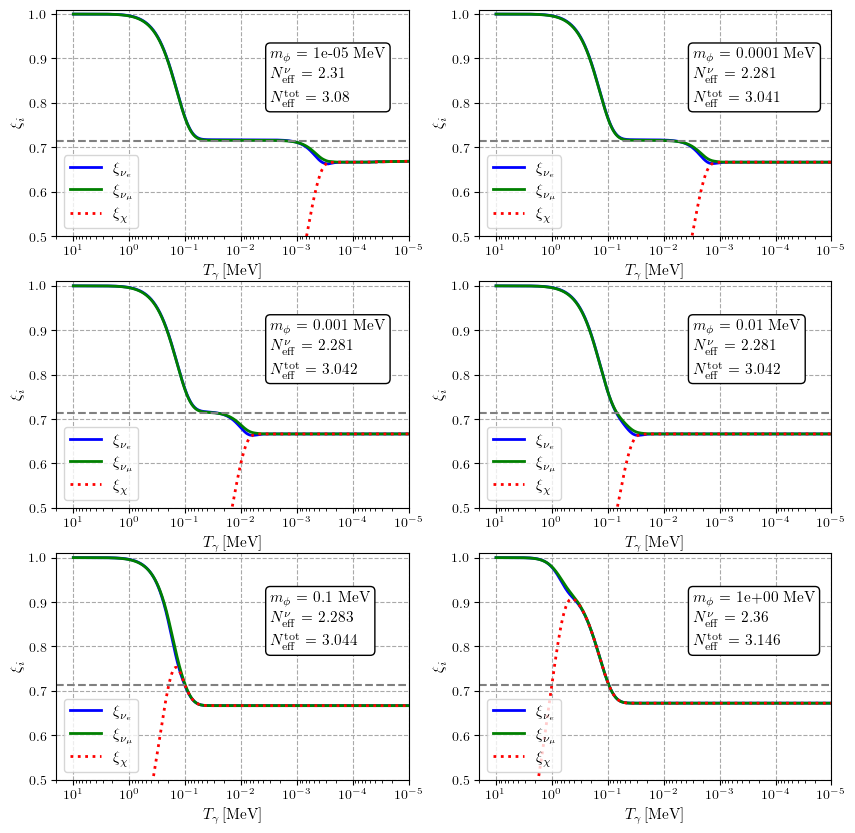

In [37]:
fixed_Lnu = 1e-1

ref_inputs = inputs[inputs['phi-NN coupling'] == fixed_Lnu]


ref_Ty_df = pd.DataFrame(Ty_df.to_numpy().T[(inputs['phi-NN coupling'] == fixed_Lnu).to_numpy()].T)
ref_Tnu_e_df = pd.DataFrame(Tnu_e_df.to_numpy().T[(inputs['phi-NN coupling'] == fixed_Lnu).to_numpy()].T)
ref_Tnu_mu_df = pd.DataFrame(Tnu_mu_df.to_numpy().T[(inputs['phi-NN coupling'] == fixed_Lnu).to_numpy()].T)
ref_Tchi_df = pd.DataFrame(Tchi_df.to_numpy().T[(inputs['phi-NN coupling'] == fixed_Lnu).to_numpy()].T)

part_evnts = len(inputs[inputs['phi-NN coupling'] == fixed_Lnu])

fig, ax = plt.subplots(3,2, figsize=(10, 10))

i = 0
sel_list = np.arange(0,part_evnts,3)

for ax1 in ax.flatten():
    sel = sel_list[i]
    i+=1
    
    LphiNN = ref_inputs.iloc[sel,:]['phi-NN coupling']
    M_phi = ref_inputs.iloc[sel,:]['M_phi']

    case_dep_df = pd.DataFrame()
    case_dep_df['time'] = time
    case_dep_df['Ty'] = ref_Ty_df.iloc[:, sel]
    case_dep_df['Tnu_e'] = ref_Tnu_e_df.iloc[:, sel]
    case_dep_df['Tnu_mu'] = ref_Tnu_mu_df.iloc[:, sel]
    case_dep_df['Tchi'] = ref_Tchi_df.iloc[:, sel]
    
    case_dep_df['Tnu_e/Ty'] = case_dep_df['Tnu_e']/case_dep_df['Ty']
    case_dep_df['Tnu_mu/Ty'] = case_dep_df['Tnu_mu']/case_dep_df['Ty']
    case_dep_df['Tchi/Ty'] = case_dep_df['Tchi']/case_dep_df['Ty']
    
    N_eff_tot = Neff(case_dep_df['Ty'].iloc[-1],
                     case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1],
                     case_dep_df['Tchi'].iloc[-1])
    
    N_eff_nu = Neff_nu(case_dep_df['Ty'].iloc[-1],
                     case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1])

    #print(f'\nselected event number = {sel}')
    #print(f'Mass of phi = {M_phi} MeV,  lambda_phiNN = {LphiNN}')
    #print(f'Neff_tot = {N_eff_tot:.4}')
    #print(f'Neff_nu = {N_eff_nu:.4}')
    
    case_dep_df.plot(x = 'Ty', y = ['Tnu_e/Ty', 'Tnu_mu/Ty', 'Tchi/Ty'], style = ['b', 'g-', 'r:'], lw=2,
                     logx=True, ylim = [0.5, 1.01], xlim = [1e-5,2e1], ax = ax1).invert_xaxis()
    ax1.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 1.5)
    
    ax1.set_xlabel(r'$T_{\gamma}\,$[MeV]',fontsize = 11)
    ax1.set_ylabel(r'$\xi_{i}$',fontsize = 11)
    
    ax1.legend([r'$\xi_{\nu_e}$', r'${\xi_{\nu_{\mu}}}$', r'${\xi_{\chi}}$'], fontsize = 11, loc = 3)
    ax1.text(3e-3,0.8, 
             r"$m_{\phi}$ = "+f"{M_phi:.1} MeV"+"\n"+r"$N^{\nu}_{\rm{eff}}$ = "+f"{N_eff_nu:.4}"
             +"\n"+r"$N^{\rm{tot}}_{\rm{eff}}$ = "+f"{N_eff_tot:.4}", 
             color='black', fontsize = 11, linespacing = 1.6, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax1.grid(ls='dashed', color = 'darkgray')

#plt.show()
plt.savefig(f"./plots/param_scan/mN_{mN_val}MeV_fixed_Lnu_Temperature_plot.pdf",bbox_inches = 'tight')

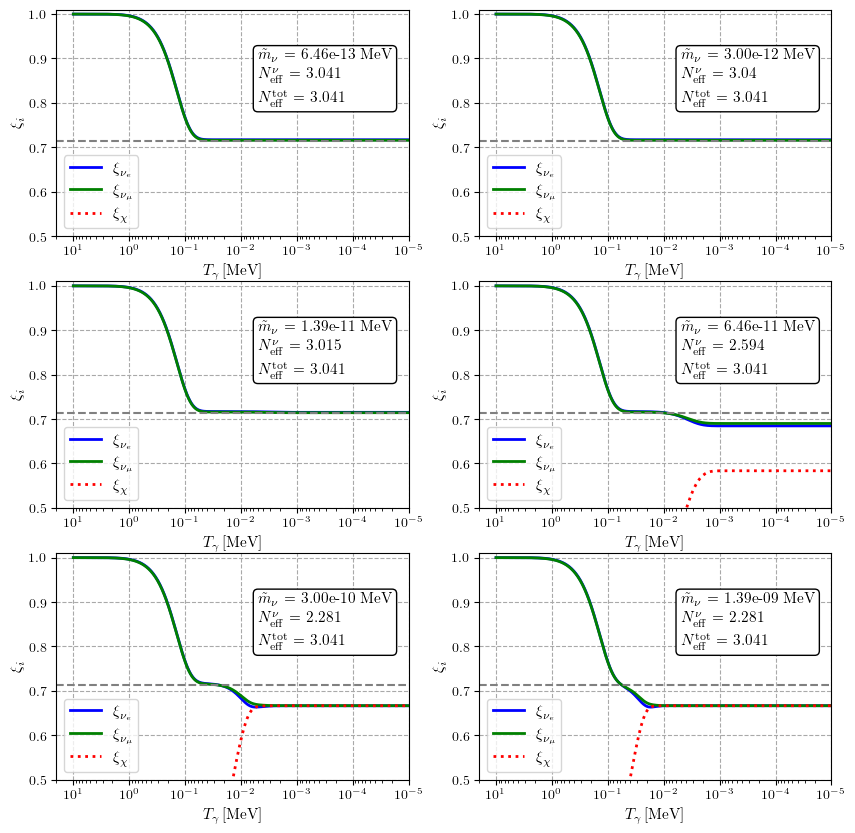

In [38]:
fixed_m_phi = 1e-2 # MeV

ref_inputs = inputs[inputs['M_phi'] == fixed_m_phi]


ref_Ty_df = pd.DataFrame(Ty_df.to_numpy().T[(inputs['M_phi'] == fixed_m_phi).to_numpy()].T)
ref_Tnu_e_df = pd.DataFrame(Tnu_e_df.to_numpy().T[(inputs['M_phi'] == fixed_m_phi).to_numpy()].T)
ref_Tnu_mu_df = pd.DataFrame(Tnu_mu_df.to_numpy().T[(inputs['M_phi'] == fixed_m_phi).to_numpy()].T)
ref_Tchi_df = pd.DataFrame(Tchi_df.to_numpy().T[(inputs['M_phi'] == fixed_m_phi).to_numpy()].T)

part_evnts = len(inputs[inputs['M_phi'] == fixed_m_phi])

fig, ax = plt.subplots(3,2, figsize=(10, 10))

i = 0
sel_list = np.arange(1,part_evnts,2)

for ax1 in ax.flatten():
    sel = sel_list[i]
    i+=1
    
    LphiNN = ref_inputs.iloc[sel,:]['phi-NN coupling']
    M_phi = ref_inputs.iloc[sel,:]['M_phi']

    case_dep_df = pd.DataFrame()
    case_dep_df['time'] = time
    case_dep_df['Ty'] = ref_Ty_df.iloc[:, sel]
    case_dep_df['Tnu_e'] = ref_Tnu_e_df.iloc[:, sel]
    case_dep_df['Tnu_mu'] = ref_Tnu_mu_df.iloc[:, sel]
    case_dep_df['Tchi'] = ref_Tchi_df.iloc[:, sel]
    
    case_dep_df['Tnu_e/Ty'] = case_dep_df['Tnu_e']/case_dep_df['Ty']
    case_dep_df['Tnu_mu/Ty'] = case_dep_df['Tnu_mu']/case_dep_df['Ty']
    case_dep_df['Tchi/Ty'] = case_dep_df['Tchi']/case_dep_df['Ty']
    
    
    N_eff_tot = Neff(case_dep_df['Ty'].iloc[-1],
                     case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1],
                     case_dep_df['Tchi'].iloc[-1])
    
    N_eff_nu = Neff_nu(case_dep_df['Ty'].iloc[-1],
                     case_dep_df['Tnu_e'].iloc[-1], case_dep_df['Tnu_mu'].iloc[-1])

    
    case_dep_df.plot(x = 'Ty', y = ['Tnu_e/Ty', 'Tnu_mu/Ty', 'Tchi/Ty'], style = ['b','g-','r:'], lw=2,
                     logx=True, ylim = [0.5, 1.01], xlim = [1e-5,2e1], ax = ax1).invert_xaxis()
    
    ax1.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 1.5)
    
    ax1.set_xlabel(r'$T_{\gamma}\,$[MeV]',fontsize = 11)
    ax1.set_ylabel(r'$\xi_{i}$',fontsize = 11)
    
    ax1.legend([r'$\xi_{\nu_e}$', r'${\xi_{\nu_{\mu}}}$', r'${\xi_{\chi}}$'], fontsize = 11, loc = 3)
    ax1.text(5e-3,0.8, 
             r"$\tilde{m}_{\nu}$ = "+f"{LphiNN*m_nl1:.2e} MeV"+"\n"+r"$N^{\nu}_{\rm{eff}}$ = "+f"{N_eff_nu:.4}"
             +"\n"+r"$N^{\rm{tot}}_{\rm{eff}}$ = "+f"{N_eff_tot:.4}", 
             color='black', fontsize = 11, linespacing = 1.6, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax1.grid(ls='dashed', color = 'darkgray')

#plt.show()
plt.savefig(f"./plots/param_scan/mN_{mN_val}MeV_fixed_mphi_Temperature_plot.pdf",bbox_inches = 'tight')

<Axes: xlabel='time'>

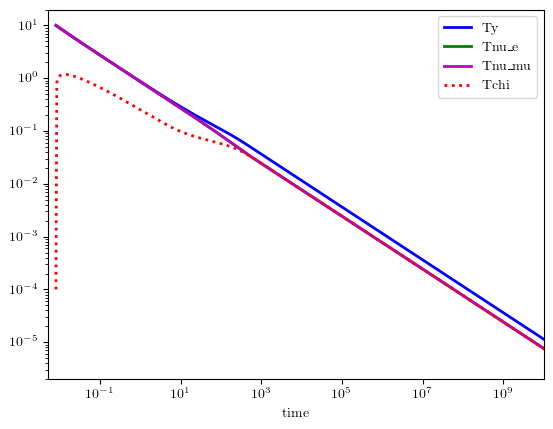

In [19]:
sel = -5

case_dep_df = pd.DataFrame()
case_dep_df['time'] = time
case_dep_df['Ty'] = ref_Ty_df.iloc[:, sel]
case_dep_df['Tnu_e'] = ref_Tnu_e_df.iloc[:, sel]
case_dep_df['Tnu_mu'] = ref_Tnu_mu_df.iloc[:, sel]
case_dep_df['Tchi'] = ref_Tchi_df.iloc[:, sel]

fig, ax = plt.subplots(1)

case_dep_df.plot(x = 'time', y = ['Ty','Tnu_e', 'Tnu_mu',  'Tchi'], style = ['b','g-', 'm','r:'], lw=2,
                 logx=True, logy=True, ylim = [2e-6, 2e1], xlim = [5e-3,1e10], ax = ax)


